In [1]:
# Pytorch Libraries
import torch 
import torchvision 
import torch.nn as nn
from torchvision import datasets, transforms,models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim 
import optuna
import albumentations as A
from albumentations.pytorch import ToTensorV2

# some other useful Libraries
import cv2
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import copy
from PIL import Image
from pandas.core.common import flatten  


In [2]:
train_transforms = A.Compose(
    [   
        A.Resize(224, 224),
#         A.CLAHE(),  
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=.2),        
            A.Blur(blur_limit=3, p=.2),              
        ], p=0.2),                                  

#         A.OneOf([                                      
#             A.OpticalDistortion(p=0.1),               
#             A.GridDistortion(p=0.1),
#         ], p=.2),

#         A.SmallestMaxSize(max_size=350),
#         A.RandomBrightnessContrast(p=0.2), 
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)
val_transforms = A.Compose(
    [
        A.Resize(224, 224),
#         A.CLAHE(),
#         A.SmallestMaxSize(max_size=220),
#         A.RandomBrightnessContrast(p=0.2),
        A.CenterCrop(height=200, width=200),

        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

test_transforms = A.Compose(
    [   
        A.Resize(224, 224),
#         A.CLAHE(),  
#         A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=200, width=200),
#         A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

In [3]:
path = r'../input/caltech256/256_ObjectCategories/'


In [4]:
Images = []
categories = ['178.school-bus', '043.coin', '056.dog', '235.umbrella-101', '024.butterfly', '111.house-fly', '057.dolphin-101'
           '067.eyeglasses', '127.laptop-101', '102.helicopter-101','232.t-shirt', '199.spoon', '012.binoculars',
           '027.calculator', '001.ak47', '189.snail', '242.watermelon', '029.cannon', '054.diamond-ring', 
           '171.refrigerator', '148.mussels', '125.knife', '115.ice-cream-cone', '170.rainbow', '213.teddy-bear',
              '209.sword','101.head-phones',  '131.lightbulb', '145.motorbikes-101', '216.tennis-ball']

classes = []
for i in categories:
    for image in glob.glob(path+i):
         classes.append(image.split('/')[-1])
#        for image_paths in glob.glob(image+'/'+i):
        
         Images.append(glob.glob(image+'/*'))

Images = list(flatten(Images))  # converting Higher dim to lower dim
random.shuffle(Images)

print('\n',Images[6])
# print(classes)
# print(Images)
print('\nTotal Classes are, ', len(classes))

print('\nsize of Images are:', len(Images))


 ../input/caltech256/256_ObjectCategories/232.t-shirt/232_0331.jpg

Total Classes are,  28

size of Images are: 4038


In [5]:
classes


['178.school-bus',
 '043.coin',
 '056.dog',
 '235.umbrella-101',
 '024.butterfly',
 '111.house-fly',
 '127.laptop-101',
 '102.helicopter-101',
 '232.t-shirt',
 '199.spoon',
 '012.binoculars',
 '027.calculator',
 '001.ak47',
 '189.snail',
 '242.watermelon',
 '029.cannon',
 '054.diamond-ring',
 '171.refrigerator',
 '148.mussels',
 '125.knife',
 '115.ice-cream-cone',
 '170.rainbow',
 '213.teddy-bear',
 '209.sword',
 '101.head-phones',
 '131.lightbulb',
 '145.motorbikes-101',
 '216.tennis-ball']

In [6]:
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths, test_image_paths = Images[:int(0.6*len(Images))],Images[int(0.6*len(Images)):int(0.8*len(Images))],Images[int(0.8*len(Images)):]
print("The size of whole datasets is :", len(Images))
print(f'The size of Train images are {len(train_image_paths)}')
print(f'The size of validation images are {len(valid_image_paths)}')
print(f'The size of test images are {len(test_image_paths)}')

The size of whole datasets is : 4038
The size of Train images are 2422
The size of validation images are 808
The size of test images are 808


In [7]:
## let's generate label of each class
idx_to_cls = {i:j for i, j in enumerate(classes)}
# print(idx_to_cls)
cls_to_idx = {value:key for key, value in idx_to_cls.items()}
cls_to_idx

{'178.school-bus': 0,
 '043.coin': 1,
 '056.dog': 2,
 '235.umbrella-101': 3,
 '024.butterfly': 4,
 '111.house-fly': 5,
 '127.laptop-101': 6,
 '102.helicopter-101': 7,
 '232.t-shirt': 8,
 '199.spoon': 9,
 '012.binoculars': 10,
 '027.calculator': 11,
 '001.ak47': 12,
 '189.snail': 13,
 '242.watermelon': 14,
 '029.cannon': 15,
 '054.diamond-ring': 16,
 '171.refrigerator': 17,
 '148.mussels': 18,
 '125.knife': 19,
 '115.ice-cream-cone': 20,
 '170.rainbow': 21,
 '213.teddy-bear': 22,
 '209.sword': 23,
 '101.head-phones': 24,
 '131.lightbulb': 25,
 '145.motorbikes-101': 26,
 '216.tennis-ball': 27}

In [8]:
class Caltect_dataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = cls_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label


train_dataset = Caltect_dataset(train_image_paths,train_transforms)
valid_dataset = Caltect_dataset(valid_image_paths,val_transforms) 
test_dataset = Caltect_dataset(test_image_paths,test_transforms)

In [9]:
dataloaders = {
    'train':
    DataLoader(train_dataset,
                batch_size=64,
                shuffle=True,
                num_workers=0),  
    'validation':
    DataLoader(valid_dataset,
                batch_size=64,
                shuffle=True,
                num_workers=0),  
    'test':
    DataLoader(test_dataset,
                batch_size=64,
                shuffle=True,
                num_workers=0    
    )                                
}


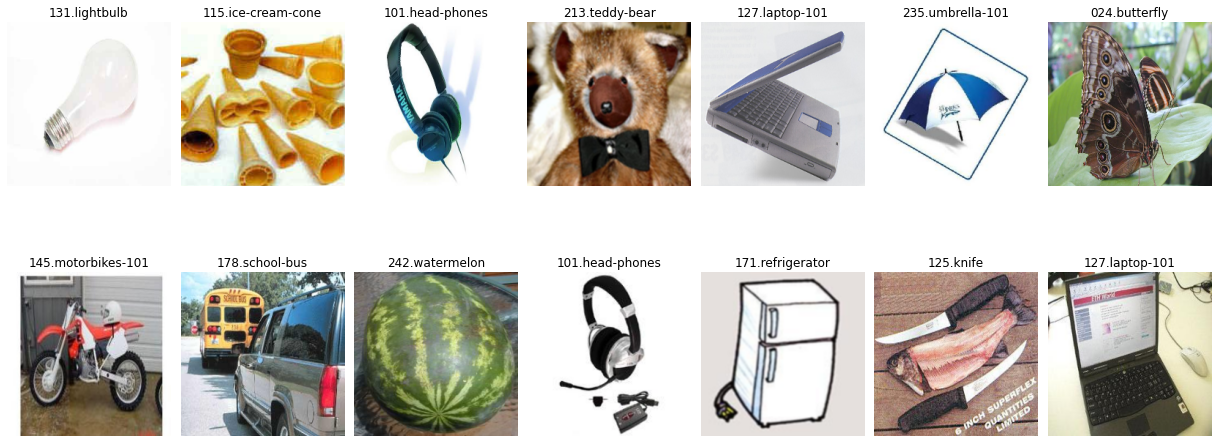

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline



def visualize_augmentations(dataset, idx=0, samples=14, cols=7, random_img = False):
    
    dataset = copy.deepcopy(dataset)

    # it is asking, if there is transform in that dataset, then take it as "t"
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))]) 
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(17, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(dataset))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_cls[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset, random_img = True)

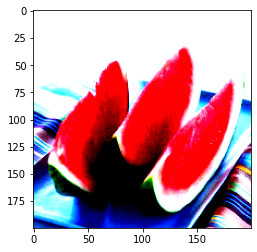

In [11]:
images, label = next(iter(dataloaders['test']))
for i, data in enumerate(images, 1):
    plt.imshow(data.permute(1,2,0).numpy())


In [12]:
model = models.efficientnet_b0(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [13]:
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [14]:
# freezing training for all layers
for params in model.parameters():
    params.requires_grad = False

In [15]:
model.classifier[1] = nn.Linear(in_features=1280, out_features=28, bias=True)

In [16]:
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

# Hyper parameters

In [17]:
from torch.optim import lr_scheduler
import time
optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device=device)
lambda2 = lambda epoch: 0.95**epoch
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda2)
# writer = SummaryWriter()
# from albumentation.pytorch import ToTensorv2

In [18]:
def visualize_loss(num_epochs, Training_Loss, Validation_Loss):
    print("\nGraphs of Losses")
    epochGraph = range(1, num_epochs+1)
    figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    figure.suptitle("Losses w.r.t Epochs", weight='bold', size=30)
    ax1.set_title('Training loss')
    ax1.plot(epochGraph,Training_Loss, 'tab:orange')
    ax2.set_title('Validation loss')
    ax2.plot( epochGraph,Validation_Loss, 'tab:green')

In [19]:
def train_model(model, criterion, optimizer,scheduler, num_epochs=3,patience=10, checkpoint=True):
    # Early stopping
    last_loss = 100
    patience = patience
    trigger_times = 0   
    Training_Loss = []
    Validation_Loss = []
    best_acc = 0

    since = time.time() 

    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Loss 
                outputs= model(inputs)
                loss = criterion(outputs, labels)
                # Optimization
                # with torch.no_grad if phase=='Train':
                if phase == 'train':
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
        


                _, preds = torch.max(outputs, 1)  # 1 = Row wise max, preds = index of max predicted image, for comparing to label
                running_loss += loss.item() * inputs.size(0)  # for getting Cost 
                running_corrects += torch.sum(preds == labels.data)

            if phase=='train':
                epoch_loss = running_loss / len(train_dataset)
                Training_Loss.append(epoch_loss)
                epoch_acc = running_corrects.double() / len(train_dataset)
                print(f'{phase} loss is: {epoch_loss:.4f}, and accuracy is : {epoch_acc:.4f}')
                
            else:
                epoch_loss = running_loss / len(test_dataset) # lenght will be same for val, train
                epoch_acc = running_corrects.double() / len(test_dataset)
                Validation_Loss.append(epoch_loss)
                print(f'{phase} loss is: {epoch_loss:.4f}, and accuracy is: {epoch_acc:.4f}\n')
                
                if epoch_acc>best_acc and checkpoint:
                    print(f'So far, {epoch} epoch has best model.\n ==> saving checkpoints\n')
                    checkpoint = {'State_dic':model.state_dict(), 'Optimizer': optimizer.state_dict()}
                    torch.save(checkpoint, 'checkpoint.tar')                    
                    best_acc = epoch_acc 
                
                # Custom Early Stopping
                if epoch_loss > last_loss:
                    trigger_times += 1
                    print('Trigger Times:', trigger_times)
                    
                    if trigger_times >= patience:
                        return ('Sorry for Early stopping, Model is not improving....')
                else:
                    print('Trigger Times: 0')

                last_loss = epoch_loss
    
    # Extra Stuff    
    # 1) Time Calculation
    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m { time_elapsed % 60:.0f}s')
    
    # 2) Plotting Graphs
    visualize_loss(num_epochs, Training_Loss, Validation_Loss)
    



Epoch 1/50
----------
train loss is: 0.8321, and accuracy is : 0.7874
validation loss is: 0.4779, and accuracy is: 0.8787

So far, 0 epoch has best model.
 ==> saving checkpoints

Trigger Times: 0

Epoch 2/50
----------
train loss is: 0.2332, and accuracy is : 0.9335
validation loss is: 0.4466, and accuracy is: 0.8812

So far, 1 epoch has best model.
 ==> saving checkpoints

Trigger Times: 0

Epoch 3/50
----------
train loss is: 0.2215, and accuracy is : 0.9294
validation loss is: 0.4532, and accuracy is: 0.8824

So far, 2 epoch has best model.
 ==> saving checkpoints

Trigger Times: 1

Epoch 4/50
----------
train loss is: 0.2083, and accuracy is : 0.9381
validation loss is: 0.4426, and accuracy is: 0.8824

Trigger Times: 0

Epoch 5/50
----------
train loss is: 0.2052, and accuracy is : 0.9434
validation loss is: 0.4435, and accuracy is: 0.8837

So far, 4 epoch has best model.
 ==> saving checkpoints

Trigger Times: 2

Epoch 6/50
----------
train loss is: 0.2109, and accuracy is : 0.9

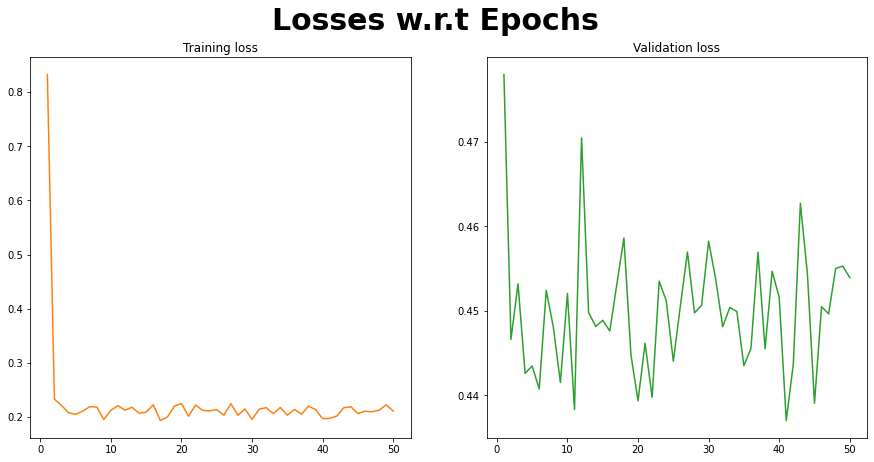

In [20]:
train_model(model, criterion, optimizer, scheduler, num_epochs=50,patience=25, checkpoint=True)

In [21]:
checkpoint = torch.load('checkpoint.tar')
model.load_state_dict(checkpoint['State_dic'])
optimizer.load_state_dict(checkpoint['Optimizer'])

# torch.save(model)

In [22]:
def check_accuracy(loader, model, train=True):
    num_correct = num_samples = 0
    model.eval()
    
    
    with torch.no_grad():
      for input, labels in loader:
        input = input.to(device=device)
        labels = labels.to(device=device)
        batch_size = input.shape[0]
    
        outputs = model(input)
        _, preds = outputs.max(1)
        num_correct += (preds == labels).sum()
        num_samples += preds.size(0)
    
    accuracy = (num_correct.item()/num_samples)*100
    
    print(f"Model Predicted {num_correct.item()} correctly out of {num_samples} from Testing dataset, Accuracy : {accuracy:.2f}")

    model.train()


    
check_accuracy (dataloaders['test'], model, train=False)

Model Predicted 729 correctly out of 808 from Testing dataset, Accuracy : 90.22


In [23]:
# model = torch.load(PATH)
import io
model.eval()

def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(200),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)


def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    tensor = tensor.to(device)
    output = model(tensor)

    prob, classes = torch.max(output, 1)
    name=idx_to_cls[classes.item()]
    return name

def read_image(image_path):
#     image_path = input("Past the Path - ")
    # Need to convert Image_path into Image for watching at the end
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    f = open(image_path, 'rb') 
    image_bytes = f.read()
    # need to give original image path, because it is transforming
    name= get_prediction(image_bytes=image_bytes)
    name = name.split('.')[-1]

    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f"This is {name}")

# read_image(image_path)

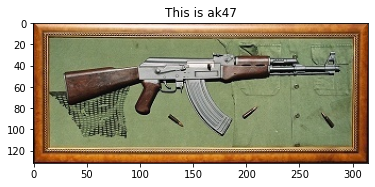

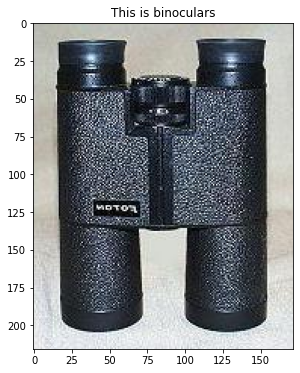

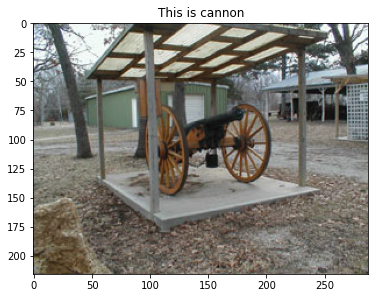

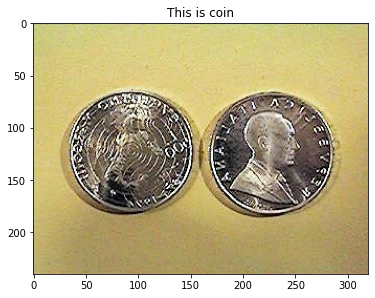

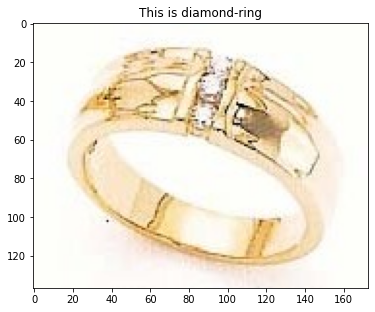

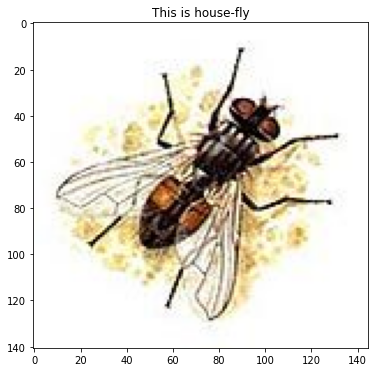

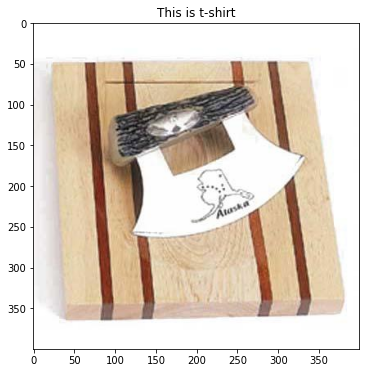

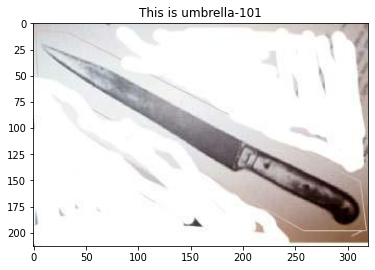

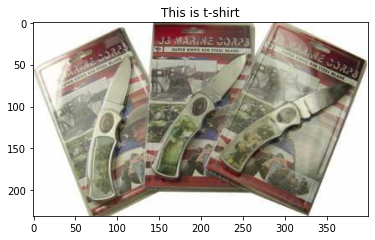

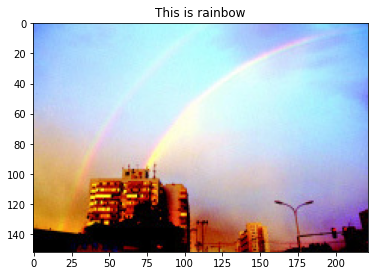

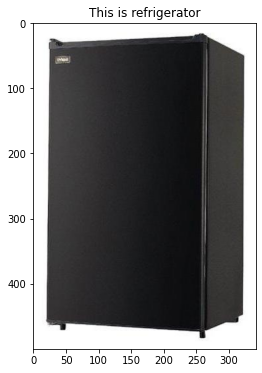

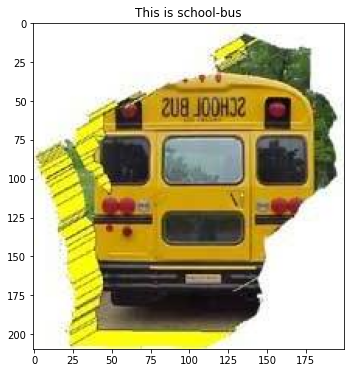

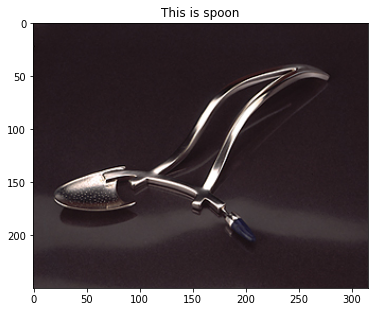

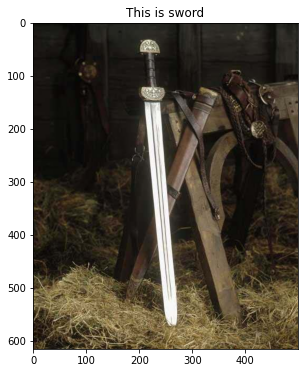

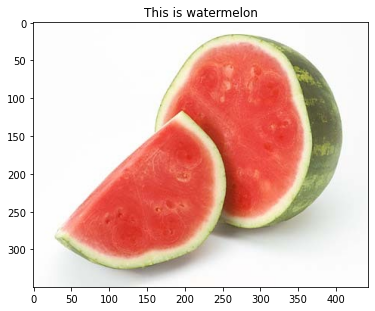

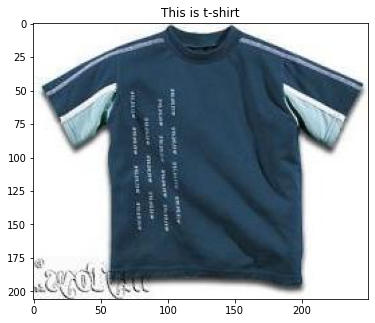

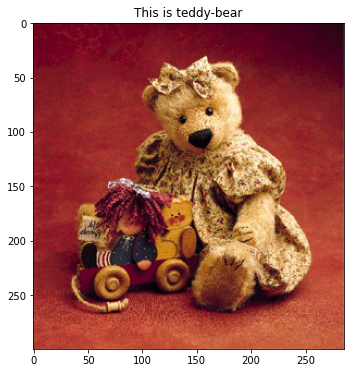

In [24]:
image_path =['../input/caltech256/256_ObjectCategories/001.ak47/001_0011.jpg',
            '../input/caltech256/256_ObjectCategories/012.binoculars/012_0010.jpg',
             '../input/caltech256/256_ObjectCategories/029.cannon/029_0014.jpg',
             '../input/caltech256/256_ObjectCategories/043.coin/043_0012.jpg',
             '../input/caltech256/256_ObjectCategories/054.diamond-ring/054_0007.jpg',
             '../input/caltech256/256_ObjectCategories/111.house-fly/111_0010.jpg',
             '../input/caltech256/256_ObjectCategories/125.knife/125_0010.jpg',
             '../input/caltech256/256_ObjectCategories/125.knife/125_0004.jpg',
             '../input/caltech256/256_ObjectCategories/125.knife/125_0030.jpg',
             '../input/caltech256/256_ObjectCategories/170.rainbow/170_0005.jpg',
             '../input/caltech256/256_ObjectCategories/171.refrigerator/171_0008.jpg',
             '../input/caltech256/256_ObjectCategories/178.school-bus/178_0027.jpg',
             '../input/caltech256/256_ObjectCategories/199.spoon/199_0025.jpg',
             '../input/caltech256/256_ObjectCategories/209.sword/209_0014.jpg',
             '../input/caltech256/256_ObjectCategories/242.watermelon/242_0012.jpg',
             '../input/caltech256/256_ObjectCategories/232.t-shirt/232_0007.jpg',
             '../input/caltech256/256_ObjectCategories/213.teddy-bear/213_0004.jpg'
            ]
for i in image_path:
    read_image(i)